In [19]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime
import backtrader as bt
% matplotlib inline
#####################
M = 600 # 计算最新标准分 zscore，rsrs_score 参考最近 M 天
stock_problem_data={'Code':[],'Name':[]}
#####################
class StockData():   
    def __init__(self,url):
        self.data_df    = []
        self.url        = url
        self.f          = None
        self.read_line  = None
        self.line       = None
        self.stock_info = None
        self.stock_data = None
        self.stock_dict = {}
        self.All_stock_dict = {'Code':[],'Name':[],'Frequency':[],'DataDf':[]}
    def data_clean(self):
        try:
            with open(self.url,'r') as self.f:
                while True:
                    self.read_fline = self.f.readline()            # 按行读取
                    if not self.read_fline:
                        break
                    self.line = self.read_fline.strip()            # 去除空格和换行符
                    if not self.line:
                        continue
                    self.data_df.append(self.line.split('\t'))     # 按照“\t”分割字符串，并且放入data中    
        except:
            print('The data_clean fuction in StockData Class executes error') 
        self.data_df             =  pd.DataFrame(self.data_df)  
        self.stock_info          =  np.array(self.data_df.iloc[0])      # 取 dataframe 的第一行元素
        self.stock_info          =  self.stock_info[0].split()          # .split() 将字符串转化为列表
        self.stock_data          =  self.data_df.iloc[1:-1]             # 从dataframe取出真实价量数据
        # self.stock_data          =  self.stock_data.iloc[::-1]        # dataframe 逆序排列。所得结果：最新数据行索引为【0】
        self.stock_data          =  self.stock_data.drop([1],axis=0)    # 删除第一行文字索引
        self.stock_data.index    =  np.arange(self.stock_data.shape[0])                     # 行索引命名
        self.stock_data.columns  =  ['Date','Open','High','Low','Close','Vol','Vocc']       # 列索引命名
    def data_store(self):
        dict={}
        self.data_clean()
        if not np.any(self.stock_data.isnull()) and len(self.stock_data) >= M:
            self.All_stock_dict['Code'].append(self.stock_info[0])            # 将本支股票的代码放入全局变量中
            self.All_stock_dict['Name'].append(self.stock_info[1])            # 将本支股票的名字放入全局变量中
            self.All_stock_dict['Frequency'].append(self.stock_info[-2])      # 将本支股票的看盘周期放入全局变量中
    #        All_stock_dict['DataDf'].append(self.stock_data)                 # 将本支股票的历史数据放入全局变量中
            dict['datetime']  =  np.array(self.stock_data['Date'])            # 将本支股票的历史数据放入全局变量中
            dict['open']  =  np.array(self.stock_data['Open']).astype(float)          # 将本支股票的历史数据放入全局变量中
            dict['high']  =  np.array(self.stock_data['High']).astype(float)          # 将本支股票的历史数据放入全局变量中
            dict['low']   =  np.array(self.stock_data['Low']).astype(float)           # 将本支股票的历史数据放入全局变量中
            dict['close'] =  np.array(self.stock_data['Close']).astype(float)         # 将本支股票的历史数据放入全局变量中
            dict['volume']   =  np.array(self.stock_data['Vol']).astype(float)                # 将本支股票的历史数据放入全局变量中
            dict['openinterest']  =  np.array(self.stock_data['Vocc']).astype(float)          # 将本支股票的历史数据放入全局变量中
            self.All_stock_dict['DataDf'].append(dict)
        else:
            stock_problem_data['Code'].append(self.stock_info[0])
            stock_problem_data['Name'].append(self.stock_info[1])
    def get_data(self,begin_time = None,end_time = None):
        self.data_store()
        if self.All_stock_dict['DataDf'] != []:
            if self.All_stock_dict['Code'][0][:3] == str('600') or str('601') or str('603') or str('000') or str('002'):
                self.All_stock_dict['DataDf'][0]['datetime'] = pd.to_datetime(self.All_stock_dict['DataDf'][0]['datetime'],format='%Y-%m-%d %H:%M:%S')
                df = pd.DataFrame(self.All_stock_dict['DataDf'][0])
                order = ['datetime','open','high','low','close','volume','openinterest']
                df = df[order]
                if (begin_time or end_time) is not None:
                    a = df[df.datetime==begin_time].index.tolist()[0]
                    b = df[df.datetime==end_time].index.tolist()[0]
                    return df[a:(b+1)],self.All_stock_dict['Code'][0]
                else:
                    return df[0:],self.All_stock_dict['Code'][0]
            else:
                return None,None
        else:
            return None,None

In [20]:
class stampDutyCommissionScheme(bt.CommInfoBase):
    '''
    本佣金模式下，买入股票仅支付佣金，卖出股票支付佣金和印花税.    
    '''
    params = (
        ('stamp_duty', 0.005),  # 印花税率
        ('commission', 0.001),  # 佣金率
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
    )

    def _getcommission(self, size, price, pseudoexec):
        '''
        If size is greater than 0, this indicates a long / buying of shares.
        If size is less than 0, it idicates a short / selling of shares.
        '''

        if size > 0:  # 买入，不考虑印花税
            return size * price * self.p.commission
        elif size < 0:  # 卖出，考虑印花税
            return - size * price * (self.p.stamp_duty + self.p.commission)
        else:
            return 0  # just in case for some reason the size is 0.

In [21]:
class get_feeds():
    def __init__(self,dataframe,nameself):
        self.dataframe  = dataframe
        self.nameself   = nameself
        self.begin_time = dataframe['datetime'].tolist()[0]
        self.end_time   = dataframe['datetime'].tolist()[-1]
    def run_self(self):
        self.feeds = bt.feeds.PandasData(
            name=self.nameself, 
            dataname=self.dataframe,
            fromdate=self.begin_time,  
            todate=self.end_time,
            datetime=0,  
            open=1,  
            high=2,  
            low=3,  
            close=4,  
            volume=5,  
            openinterest=-1  
        )
        return self.feeds

In [22]:
class result_plot():
    def __init__(self):
        pass
    def plot_simple(self,x_series,y_series,title,x_lable,y_lable):
        # 设置中文字体
        plt.rcParams['axes.unicode_minus'] = False    # 不使用中文减号
        plt.rcParams['font.sans-serif'] = 'FangSong'  # 设置字体为仿宋（FangSong）
        # 画布
        self.fig = plt.figure(figsize=(25,10),  # inches
                         dpi=120, # dot-per-inch
                         facecolor='#BBBBBB',
                         frameon=True, # 画布边框
                        )  
        plt.plot(x_series,y_series,'b-',label=title)
        # 中文标题
        plt.title(title)
        # 字体字典
#         self.font_dict=dict(fontsize=8,
#                       color='k',
#                       family='SimHei',
#                       weight='light',
#                       style='italic',
#                       )
#         # X轴标签
#         plt.xlabel(x_lable, loc='center', fontdict=self.font_dict)   # loc: 左中右 left center right
#         # Y轴标签
#         plt.ylabel(y_lable,loc='top', fontdict=self.font_dict)  # loc: 上中下 top center bottom
#         # X轴范围
#         plt.xlim((2000,2010))  # X轴的起点和终点
#         # Y轴范围
#         plt.ylim(6e9,7e9) # Y轴的起点和终点
#         # X轴刻度
#         plt.xticks(np.arange(2000,2011))
#         # X轴刻度
#         plt.yticks(np.arange(6e9,7e9+1e8,1e8))
        # 图例
        plt.legend()
        # plt.legend(labels=['人口'])
        # 网格线
        plt.grid(axis='both')  # axis: 'both','x','y'
    def plot_varies(self,xy_df,title_list):
        for a,b in zip(range(len(xy_df.columns)),title_list):    
            plt.plot(xy_df[0],xy_df[a+1],label=b)
            plt.legend()

In [23]:
class algorithm():
    def __init__(self,data,adjust_period=29,max_period=365,flag=False):
        self.data = data
        self.N    = adjust_period # 标的股票历史数据回归拟合周期
        self.M    = max_period    
        self.move_period = self.N - 11
        self.score_threshold = 0.7
        if not flag:
            if len(self.data) > self.N:
                self.close_29 = np.array(self.data.close.get(ago=0,size=self.N))
            else:
                print('指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！')
                return None
        else:
            if len(self.data) > self.M+self.move_period:
                self.high_618  = np.array(self.data.high.get(ago=0,size=self.M+self.move_period))
                self.low_618   = np.array(self.data.low.get(ago=0,size=self.M+self.move_period))
            else:
                print('指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！')
                return None
    def get_ols(self,x,y):
        self.x_ols = x
        self.y_ols = y
        self.slope_ols, self.intercept_ols = np.polyfit(self.x_ols, self.y_ols, 1)
        self.r2 = 1 - (sum((self.y_ols - (self.slope_ols * self.x_ols + self.intercept_ols))**2) / ((len(self.y_ols) - 1) * np.var(self.y_ols, ddof=1)))
        return (self.intercept_ols, self.slope_ols, self.r2) 
    def init_slope_series(self):
        return [self.get_ols(self.low_618[i:i+self.move_period], self.high_618[i:i+self.move_period])[1] for i in range(self.M)]
    def get_zscore(self,slop_series):
        self.slop_series_zscore = slop_series
        self.mean = np.mean(self.slop_series_zscore)
        self.std  = np.std(self.slop_series_zscore)             # 计算标准差
        return (self.slop_series_zscore[-1] - self.mean) / self.std # 标准分计算公式：Z = （X - Mean）/ 标准差
    def get_score_simple(self):
        try:
            self.y = np.log(self.close_29)
            self.x = np.arange(len(self.y))
            self.slope, self.intercept = np.polyfit(self.x, self.y, 1) # 拟合一次多项式，返回拟合直线的k、b值
        except:
            print('29日数据线性拟合错误')
            return None
        # (e ^ slope) ^ 250 - 1 ;annualized_returns 为年度回报率
        self.annualized_returns = math.pow(math.exp(self.slope), 250) - 1 # pow()方法返回x的y次幂的值
        # r_squared 是衡量线性回归效果的评价指标 R^2 =1 - sum（（yi - y）^2）/ sum((ymean - y)^2)
        self.r_squared = 1 - (sum((self.y - (self.slope * self.x + self.intercept))**2) / ((len(self.y) - 1) * np.var(self.y, ddof=1))) # np.var（）求方差
        self.score = self.annualized_returns * self.r_squared # 年化回报率*模型评价指标（负无穷--1】
        if np.isnan(self.score):
            # print('29日线性拟合所得年化回报得分为 NaN',self.data._name)
            return None
        else:
            return [self.data._name,self.score,self.data.close[0]]
    def get_timing_signal(self):
        self.i,self.s,self.r = self.get_ols(self.low_618[-self.move_period:],self.high_618[-self.move_period:]) # 函数返回值(self.intercept_ols, self.slope_ols, self.r2) 
        self.slope_series    = self.init_slope_series()
        self.rsrs_score      = self.get_zscore(self.slope_series[-self.M:])*self.r  # 正态分布得到的值
        if self.rsrs_score > self.score_threshold:
            return "BUY"
        elif self.rsrs_score < -self.score_threshold:
            return "SELL"
        else:
            return "KEEP"

In [24]:
class logic_operation():
    def __init__(self,list1,list2):
        self.list1 = list1
        self.list2 = list2
    def intersect(self):  # 交集 ,list1,2共有的
        return list(set(self.list1)&set(self.list2))
    def union(self):      # 并集，list1,2全部的(非重复)
        return list(set(self.list1)|set(self.list2))
    def difference(self): # 差集，list1所独有的
        return list(set(self.list1)-set(self.list2))

In [25]:
class Strategy(bt.Strategy):
    # 策略参数
    params = dict(
        stock_pool_num = 5,
        limit_score    = 0, 
        underlying_stock_code = '999999', # 中证1000
        ma_period=21,       # 均线周期
        adjust_period=29,   # 回归判分周期
        MAX_period=365,     # 历史正态分布周期
        pos_rate_list = [3,2,1,1],
        printlog=True
    )
    selectstock_fromset             = []
    deletestock_fromset             = []
    selectstock_fromalgorithm       = []
    deletestock_fromalgorithm       = []
    stock_select_df                 = []
    def log(self,txt,dt=None,doprint=True):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))
    def __init__(self):
        self.mas20 = dict() # {}
        #遍历所有股票,计算20日均线
        self.total_value   = self.broker.getvalue()
        self.can_use_cash  = self.broker.getcash()  # 非冻结资产
        self.total_comm    = 0
        for data in self.datas:
            self.mas20[data._name] = bt.ind.SMA(data.close, period=self.p.ma_period) 
    def next(self):
        # ￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥每根k线刷新参数￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥
        self.score_list = []
        self.signal     = False
        self.pos_count  = 0
        self.total_value   = self.broker.getvalue() # 包含股权的总资产
        self.can_use_cash  = self.broker.getcash()  # 非冻结资产
        #￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥
        for data in self.datas:
            self.t = algorithm(data,adjust_period=self.p.adjust_period).get_score_simple() # 返回单只股票的29日年化回报评分，与股票代码的列表[self.data._name,self.score]
            if self.t is not None:
                self.score_list.append(self.t)
            else:
                pass
        self.score_list_df        = pd.DataFrame(self.score_list,columns=['code','score','close'])
        self.stock_select_df      = self.score_list_df[(self.score_list_df['score']>self.p.limit_score) & (self.score_list_df['score']< 10)& (self.score_list_df['close']<self.can_use_cash/100)]
        self.stock_select_df      = self.stock_select_df.sort_values(by='score',ascending=False)
        self.stock_select_df      = self.stock_select_df[:self.p.stock_pool_num]
        self.stock_select_df      = self.stock_select_df.set_index(np.arange(len(self.stock_select_df))) # 重置索引 0-n
        # 回归算法选的股票
        self.selectstock_fromalgorithm = np.array(self.stock_select_df['code'])
        self.signal = algorithm(self.getdatabyname(self.p.underlying_stock_code),adjust_period=self.p.adjust_period,max_period=self.p.MAX_period,flag=True).get_timing_signal() # 返回"BUY"或者"SELL"或者"KEEP"
        if self.signal == "BUY":
            for i in self.selectstock_fromalgorithm:
                data = self.getdatabyname(i)
                if self.mas20[data._name][0]>self.mas20[data._name][-3] and self.signal == "BUY" and self.pos_count<len(self.p.pos_rate_list):
                    self.size=int(self.p.pos_rate_list[self.pos_count]/sum(self.p.pos_rate_list)*self.can_use_cash/100/data.close[0])*100
                    if self.size != 0 and self.size <= self.can_use_cash:
                        self.buy(data = data, size = self.size) 
                        self.pos_count += 1
                        self.can_use_cash -= self.size
                    else:
                        pass
                else:
                    pass
        else:
            pass
        if self.signal == "SELL" or self.is_bar_stop(self.datas[0]):
            for self.aa in self.broker.positions: # self.aa 为 data
                if self.broker.getposition(self.aa).size > 0:
                    if self.mas20[self.aa._name][0]<self.mas20[self.aa._name][-3] and self.signal == "SELL":
                        self.close(data = self.aa)   
                    elif self.is_bar_stop(self.datas[0]):
                        self.close(data = self.aa) 
                    else:
                        pass
                else:
                    pass
            if self.is_bar_stop(self.datas[0]):
                self.log('回测完成，执行全部强制平仓')
        else:
            pass
        profit_rate_curve['total_value'].append([self.datas[0].datetime.date(0),self.total_value]) # 传送时间和账户资产
        
        if self.is_bar_stop(self.datas[0]):  # 回测完成
            print("$"*120)
            self.log("今日选股\n%s"%self.stock_select_df)# 回测完成后，返回今日选股
            print("$"*120)
            return
        
    #记录交易执行情况（可省略，默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            pass
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log('买入执行 %s,\n价格:%s,成本:%s,手续费:%s'%(order.data._name,order.executed.price,order.executed.value,order.executed.comm))
            elif order.issell():
                self.log('卖出执行 %s,\n价格:%s,成本:%s,手续费:%s'%(order.data._name,order.executed.price,order.executed.value,order.executed.comm))
            else:
                pass
            self.bar_executed = len(self) 
        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单作废 %s, %s, isbuy=%i,issell=%i, size:%i ,开盘价 %s,当前账户资产：%s' %
                     (order.data._name, order.getstatusname(), order.isbuy(), order.issell(),order.created.size,order.data.open[0],self.can_use_cash))
        else:
            pass
        self.order = None
        
    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if trade.isclosed:
            print("$"*120)
            self.log('平仓后策略收益\n毛收益:%s,净收益:%s,总手续费:%s'%(trade.pnl,trade.pnlcomm,trade.commission))
            print("$"*120)
            self.total_comm += trade.commission
            profit_rate_curve['total_comm'].append([self.datas[0].datetime.date(0),self.total_comm])
        else:
            pass
    def is_bar_stop(self, data): 
        if len(data) >= data.buflen() - 2:
            return True 
        else: 
            return False


In [26]:
class result_resport():
    def __init__(self,results):
        self.results = results
    def get(self):     
        print('夏普比率:', self.results[0].analyzers.SharpeRatio.get_analysis()['sharperatio'])
        print('年化夏普比率:', self.results[0].analyzers.SharpeRatio_A.get_analysis()['sharperatio'])
        print('最后回撤:（长度：%s,幅度：%s,亏损货币量：%s）' % 
              (self.results[0].analyzers.DrawDown.get_analysis().len,
               self.results[0].analyzers.DrawDown.get_analysis().drawdown,
               self.results[0].analyzers.DrawDown.get_analysis().moneydown
              ))
        print('最大回撤:（长度：%s,幅度：%s,亏损货币量：%s）' % 
              (self.results[0].analyzers.DrawDown.get_analysis().max.len,
               self.results[0].analyzers.DrawDown.get_analysis().max.drawdown,
               self.results[0].analyzers.DrawDown.get_analysis().max.moneydown
              ))
        print('最终市值: %.2f' % cerebro.broker.getvalue())

全部数据完成读入
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循环超限！
29日数据线性拟合错误
指标 lines 的数据缺失，导致 backtrader 的 next() 循

2021-01-06, 买入执行 600573,
价格:12.15,成本:7290.0,手续费:0.0729
2021-01-06, 买入执行 002967,
价格:37.99,成本:3799.0,手续费:0.03799
2021-01-07, 买入执行 601919,
价格:13.8,成本:2760.0,手续费:0.027600000000000003
2021-01-07, 买入执行 600300,
价格:5.08,成本:2032.0,手续费:0.02032
2021-01-07, 买入执行 300317,
价格:7.7,成本:770.0,手续费:0.0077
2021-01-08, 买入执行 000791,
价格:4.8,成本:960.0,手续费:0.009600000000000001
2021-01-08, 买入执行 600300,
价格:4.93,成本:493.0,手续费:0.00493
2021-01-11, 买入执行 600982,
价格:3.83,成本:383.0,手续费:0.0038300000000000005
2021-01-11, 买入执行 600408,
价格:2.43,成本:243.00000000000003,手续费:0.0024300000000000003
2021-02-01, 卖出执行 600982,
价格:2.99,成本:383.0,手续费:0.30199000000000004
2021-02-01, 卖出执行 000791,
价格:4.15,成本:960.0,手续费:0.8383000000000002
2021-02-01, 卖出执行 300705,
价格:25.61,成本:2410.0,手续费:2.5866100000000003
2021-02-01, 卖出执行 600408,
价格:2.65,成本:243.00000000000003,手续费:0.26765
2021-02-01, 卖出执行 300317,
价格:6.14,成本:770.0,手续费:0.62014
2021-02-01, 卖出执行 600300,
价格:3.82,成本:2525.0,手续费:1.9291
2021-02-01, 卖出执行 600573,
价格:7.91,成本:7290.0,手续费:4.7934600000000005
$$$$$$

2021-06-15, 买入执行 002178,
价格:4.18,成本:10450.0,手续费:0.10450000000000001
2021-06-15, 买入执行 603657,
价格:25.0,成本:5000.0,手续费:0.05
2021-06-15, 买入执行 603937,
价格:13.15,成本:2630.0,手续费:0.0263
2021-06-22, 卖出执行 603657,
价格:25.45,成本:5000.0,手续费:5.1409
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2021-06-22, 平仓后策略收益
毛收益:89.99999999999986,净收益:84.80909999999986,总手续费:5.1909
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2021-06-24, 买入执行 600193,
价格:8.03,成本:4818.0,手续费:0.04818
2021-06-24, 买入执行 300793,
价格:17.4,成本:1739.9999999999998,手续费:0.0174
2021-06-24, 买入执行 300139,
价格:10.25,成本:1025.0,手续费:0.01025
2021-06-25, 买入执行 600983,
价格:11.15,成本:1115.0,手续费:0.01115
2021-06-25, 买入执行 600173,
价格:6.6,成本:660.0,手续费:0.006600000000000001
2021-06-28, 买入执行 600070,
价格:8.66,成本:866.0,手续费:0.008660000000000001
2021-06-28, 买入执行 300044,
价格:3.04,成本:608.0,手续费:0.00608
2021-06-28, 买入执行 300278,
价格:2.77

2021-11-26, 卖出执行 300443,
价格:60.9,成本:5091.0,手续费:6.1509
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2021-11-26, 平仓后策略收益
毛收益:999.0000000000002,净收益:992.7981900000002,总手续费:6.20181
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2021-12-10, 买入执行 002101,
价格:11.3,成本:11300.0,手续费:0.113
2021-12-10, 买入执行 603730,
价格:24.26,成本:4852.0,手续费:0.04852
2021-12-10, 买入执行 603879,
价格:7.74,成本:3096.0,手续费:0.03096
2021-12-10, 买入执行 002976,
价格:23.05,成本:2305.0,手续费:0.02305
2021-12-13, 买入执行 000587,
价格:1.53,成本:1683.0,手续费:0.01683
2021-12-13, 买入执行 002132,
价格:5.9,成本:590.0,手续费:0.005900000000000001
2021-12-15, 买入执行 600351,
价格:7.26,成本:726.0,手续费:0.007260000000000001
2022-01-07, 卖出执行 002976,
价格:22.18,成本:2305.0,手续费:2.24018
2022-01-07, 卖出执行 300370,
价格:2.29,成本:250.0,手续费:0.23129000000000002
2022-01-07, 卖出执行 002132,
价格:5.58,成本:590.0,手续费:0.5635800000000001
2022-01-07, 卖出执行 000587,
价格:1.6

2022-08-18, 卖出执行 600297,
价格:2.56,成本:549.0,手续费:0.51712
2022-08-18, 卖出执行 605333,
价格:29.53,成本:1970.0,手续费:2.98253
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2022-08-18, 平仓后策略收益
毛收益:-37.000000000000014,净收益:-37.522610000000014,总手续费:0.52261
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2022-08-18, 平仓后策略收益
毛收益:983.0000000000002,净收益:979.9977700000002,总手续费:3.00223
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2022-09-20, 卖出执行 300115,
价格:12.38,成本:922.0000000000001,手续费:1.25038
2022-09-20, 卖出执行 600780,
价格:5.91,成本:6420.0,手续费:7.162920000000001
2022-09-20, 卖出执行 300297,
价格:2.05,成本:178.0,手续费:0.20704999999999998
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

2023-02-09, 回测完成，执行全部强制平仓
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2023-02-09, 今日选股
     code     score  close
0  000701  9.966557   8.14
1  002747  9.954901  26.93
2  002241  9.777658  22.31
3  600212  9.721849   9.33
4  002380  9.702538  17.92
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2023-02-10, 买入执行 000701,
价格:8.1,成本:17010.0,手续费:0.1701
2023-02-10, 买入执行 002747,
价格:26.9,成本:10760.0,手续费:0.10760000000000002
2023-02-10, 买入执行 002241,
价格:22.1,成本:4420.0,手续费:0.0442
2023-02-10, 买入执行 600212,
价格:9.39,成本:4695.0,手续费:0.046950000000000006
2023-02-10, 回测完成，执行全部强制平仓
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
2023-02-10, 今日选股
     code     score  close
0  000628  9.993620  14.42
1  002174  9.975287  11.88
2  000066  9.771879  13.11
3  002717  9.765629   3.79
4  300389 

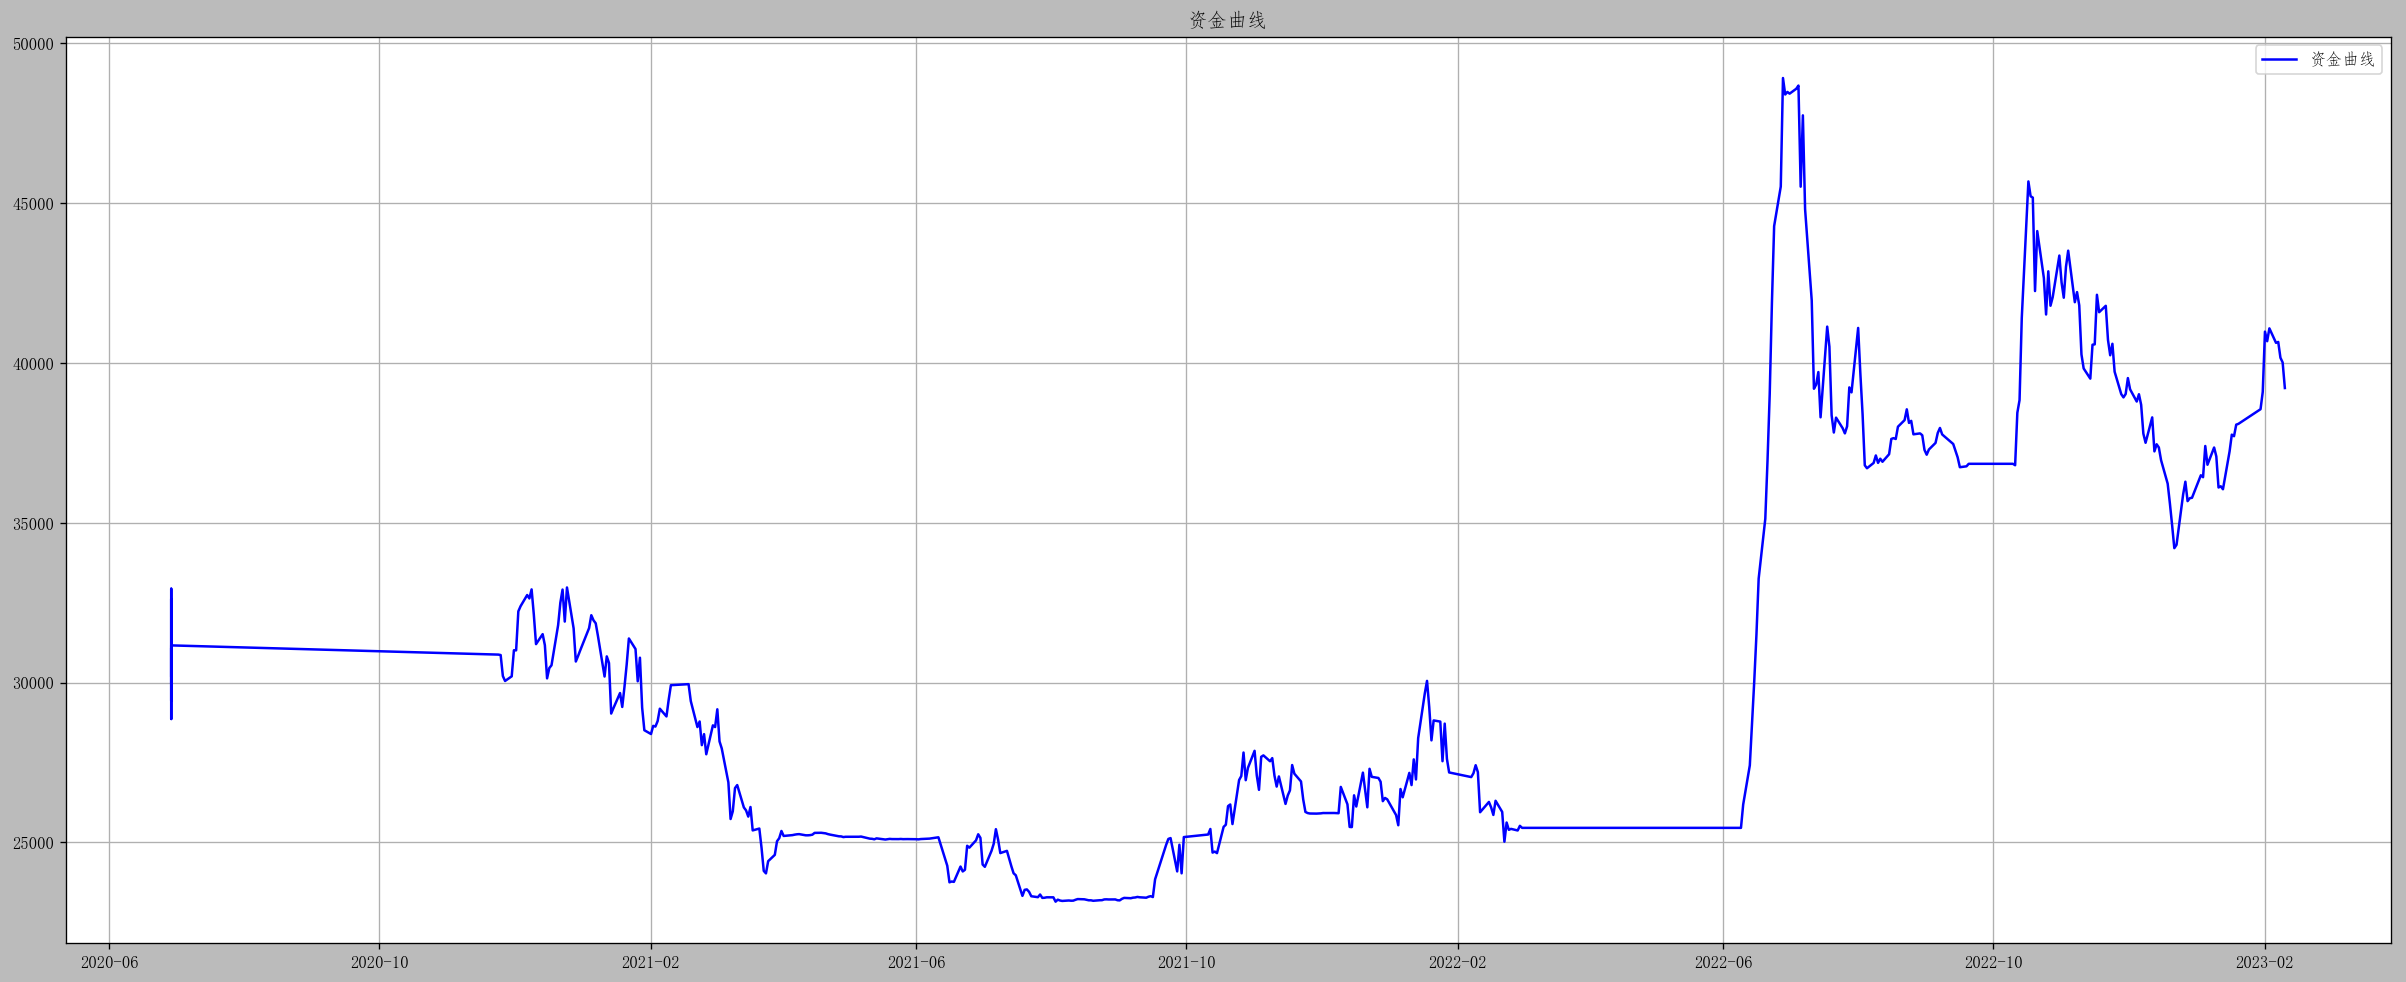

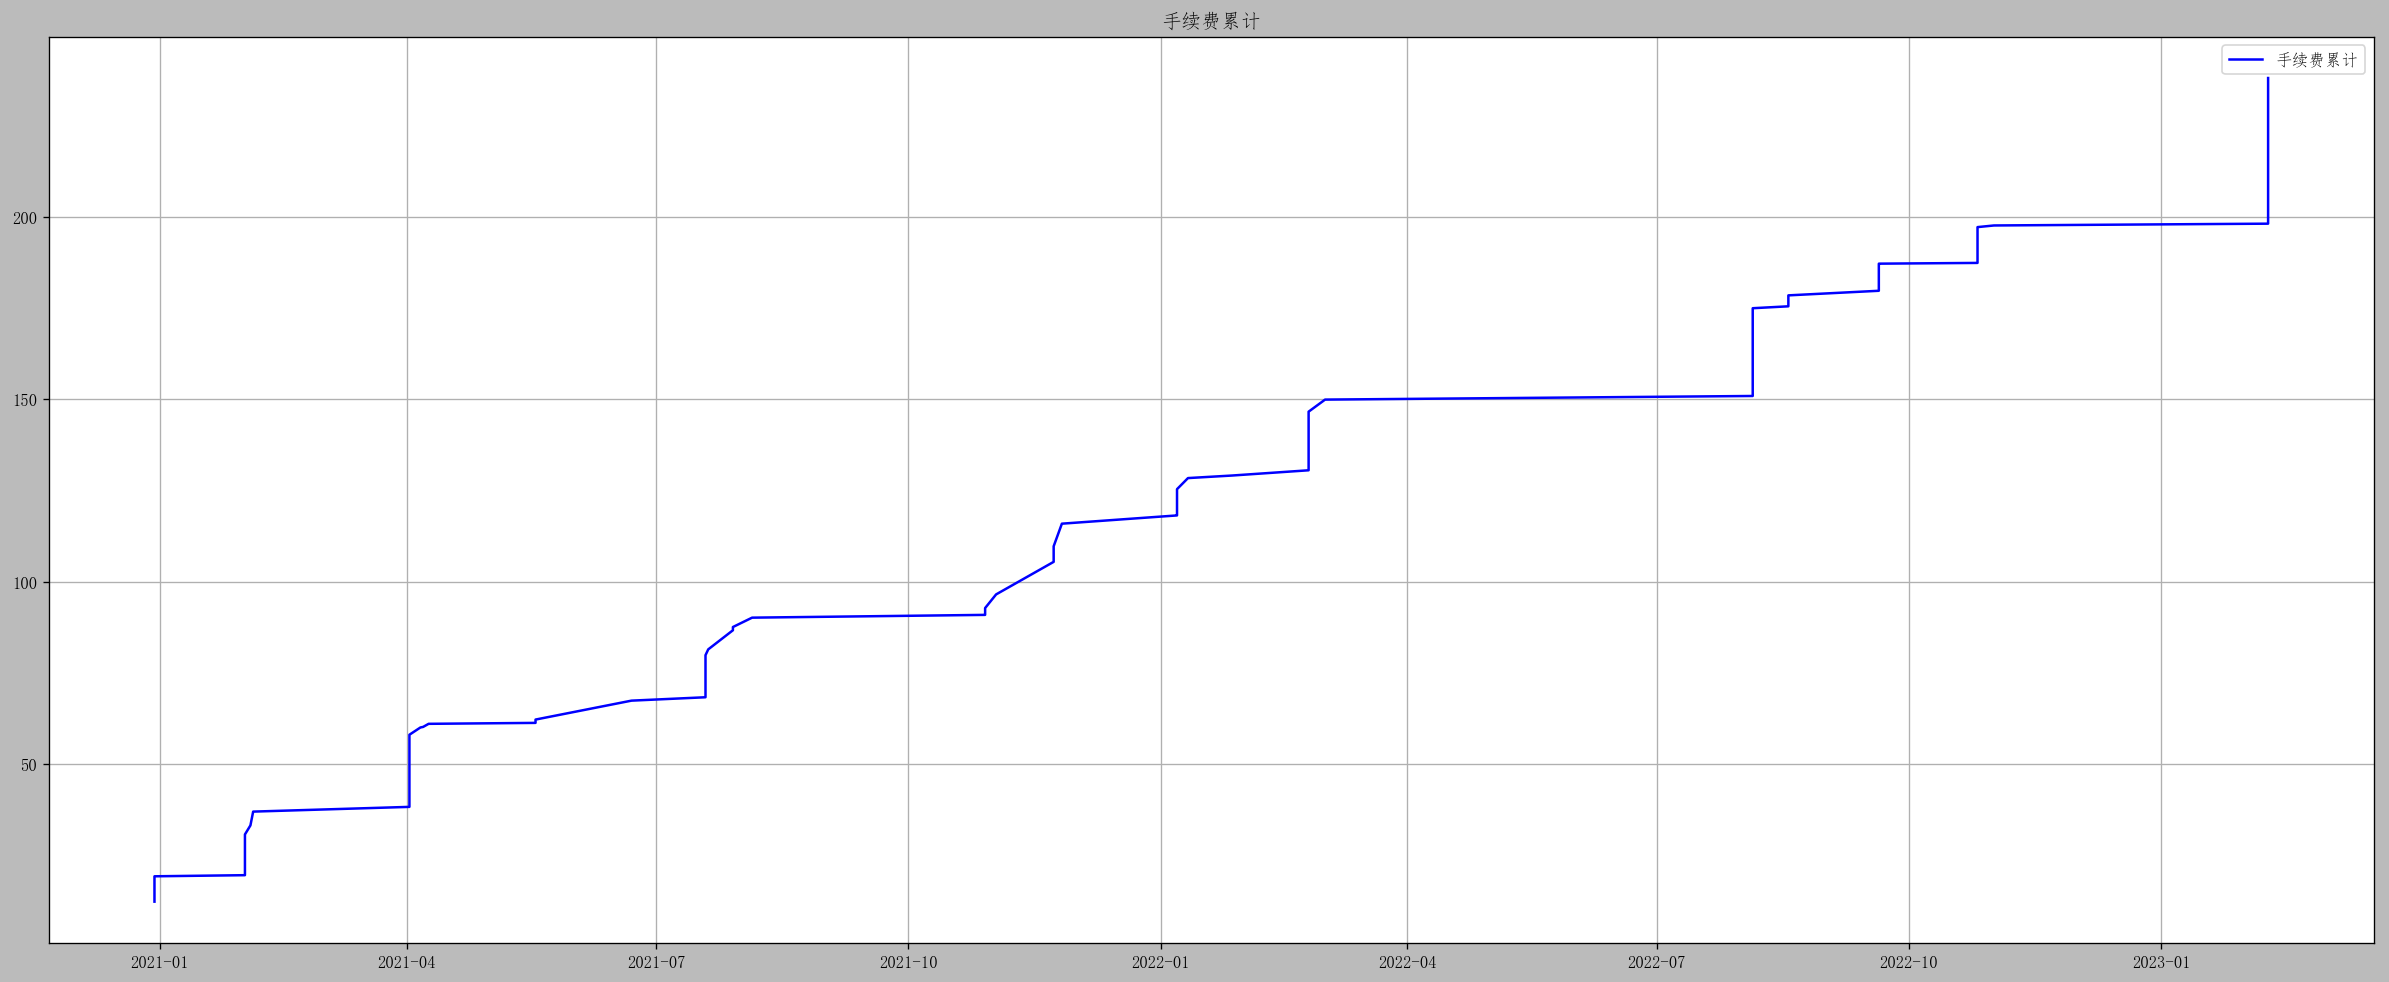

In [27]:
if __name__ == "__main__":
    profit_rate_curve = {'total_value':[],'total_comm':[]} # 存储随时间变化的收益率曲线，当调用时最好使用np.array()转化为numpy形式
    list = os.listdir('D:/Git_Multi-stocks-quant_of_Tong_da_xin/export/')
    cerebro = bt.Cerebro(tradehistory=True)
    for i in list:
        stockdata_info = StockData(url='D:/Git_Multi-stocks-quant_of_Tong_da_xin/export/' + i).get_data(begin_time = None,end_time = None)
        if (stockdata_info[0] is not None) and (stockdata_info[1] is not None):
            feed = get_feeds(stockdata_info[0],stockdata_info[1]).run_self()
            cerebro.adddata(feed)   
        else:
            pass
    print('全部数据完成读入')
    startcash = 30000
    cerebro.broker.setcash(startcash)
    comminfo = stampDutyCommissionScheme(stamp_duty=0.001, commission=0.001)
    cerebro.broker.addcommissioninfo(comminfo)
    cerebro.addstrategy(Strategy,printlog=True) 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='SharpeRatio_A')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    results = cerebro.run()    # 不进行策略参数优化时只有当前策略的分析报告作为返回值在 results 中，进行参数优化时，一组参数就有一个报告
    print("$"*120)
    result_resport(results).get() # 策略回报分析
    print("$"*120)
    #￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥ 可视化 ￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥
    profit_rate_curve_df  = np.array(profit_rate_curve['total_value'])
    profit_rate_curve_df1 = np.array(profit_rate_curve['total_comm'])
    profit_rate_curve_df  = pd.DataFrame(profit_rate_curve_df)
    profit_rate_curve_df1 = pd.DataFrame(profit_rate_curve_df1)
    result_plot().plot_simple(profit_rate_curve_df[0],profit_rate_curve_df[1],title = '资金曲线',x_lable = '时间',y_lable = '资金量')
    result_plot().plot_simple(profit_rate_curve_df1[0],profit_rate_curve_df1[1],title = '手续费累计',x_lable = '时间',y_lable = '手续费累积量')

    